# Lab Assignment Three: Extending Logistic Regression

### Authors
- Juliana Antonio
- Xiaona Hang
- Chuanqi Deng


### 1. Preparation and Overview

The "Body Performance Data" sourced from the [Korea Sports Promotion Foundation](https://www.bigdata-culture.kr/bigdata/user/data_market/detail.do?id=ace0aea7-5eee-48b9-b616-637365d665c1), available on Kaggle, comprises 13,393 rows and encompasses 12 features, such as age, gender, height, weight, and more. This dataset, meticulously curated, demonstrates the correlation between age and various exercise performance metrics, thereby providing insights into individual performance grades.

Utilizing this rich dataset, the aim is to classify individuals into distinct performance grades: A (Best), B, C, and D (Worst), based on the aforementioned 12 features. This classification is pivotal for tailoring personalized training plans, catering to diverse needs and abilities. Consequently, gyms and rehabilitation centers stand to benefit significantly from leveraging predictive analytics to craft bespoke training plans, optimizing clients' progress and well-being.

Beyond professional institutions, individuals themselves will be interested in understanding their body performance classification. Armed with this knowledge, they can make informed decisions regarding their fitness journey, setting realistic goals and embracing tailored approaches for holistic improvement.

The deployment of a robust classification model is expected to achieve an accuracy of approximately 80%. By meeting this benchmark, the model ensures reliable predictions, empowering stakeholders to make data-driven decisions with confidence.

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

raw_data = pd.read_csv("data/bodyPerformance.csv")

# preprocessing
data = pd.get_dummies(raw_data, columns=['gender'],dtype=np.int8) # one-hot encoding for gender
labels = data['class'].map(lambda c: ord(c) - ord('A')) # encode lables into integer
data.drop(['class'], axis=1, inplace=True) # remove class column

# scale
scaler = StandardScaler()
features = scaler.fit_transform(data)

# PCA
pca = PCA(8)
pca_feature = pca.fit_transform(features)
raw_data.shape, pca_feature.shape

((13393, 12), (13393, 8))

The dataset has one categorical feature, the gender. One-hot encoding is enployed to convert it into numerical data. Next, the lables/class is moved to another separate variable, lables. Then, the Standard Scaling and PCA are applied to mitigate the difference of multiple features reduce the number of features from 12 to 8.

In [2]:
# breakdown of the variables
pd.DataFrame(pca_feature).describe()

,0,1,2,3,4,5,6,7
count,1.339300e+04,1.339300e+04,1.339300e+04,1.339300e+04,1.339300e+04,1.339300e+04,1.339300e+04,1.339300e+04
mean,-1.283724e-16,-7.709306e-19,-2.368747e-17,-4.912403e-17,-2.337661e-18,2.952747e-17,-1.345398e-17,5.760945e-17
std,2.386378e+00,1.462662e+00,1.127011e+00,9.438121e-01,8.081770e-01,5.785046e-01,5.602344e-01,4.860709e-01
min,-5.041796e+00,-5.384663e+00,-7.437324e+00,-4.140902e+00,-4.012083e+00,-2.242237e+00,-5.062883e+00,-2.246422e+00
25%,-1.967484e+00,-1.012307e+00,-6.911124e-01,-6.042082e-01,-4.971976e-01,-3.845767e-01,-3.517389e-01,-3.142285e-01
50%,-8.995369e-01,1.073930e-01,5.143689e-02,1.506179e-02,7.247022e-03,1.665698e-02,8.867419e-03,-3.037003e-03
75%,2.360703e+00,1.072822e+00,7.628835e-01,6.133066e-01,5.253231e-01,3.905508e-01,3.792356e-01,3.000243e-01
max,6.506510e+00,7.782459e+00,1.473913e+01,4.345014e+00,1.360873e+01,3.636507e+00,5.873632e+00,6.967697e+00


In [3]:
# test different folds of cross validation
cross_validation_accs = {}
# n fold cross-validation, n: 3-10
for n in tqdm(range(3, 11)):
    # n-fold cross-validation
    cross_validator = KFold(n_splits=n)
    split_indices = cross_validator.split(pca_feature, labels)
    
    # training and testing
    avg_accs = []
    for train_indices, test_indices in split_indices:
        X_train, y_train = pca_feature[train_indices], labels[train_indices]
        X_test, y_test = pca_feature[test_indices], labels[test_indices]
        
        classifier = SVC()
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        avg_accs.append(acc)
    
    cross_validation_accs[n] = avg_accs

100%|██████████| 8/8 [07:52<00:00, 59.07s/it]


Text(0.5, 1.0, 'Cross Validation Accuracies')

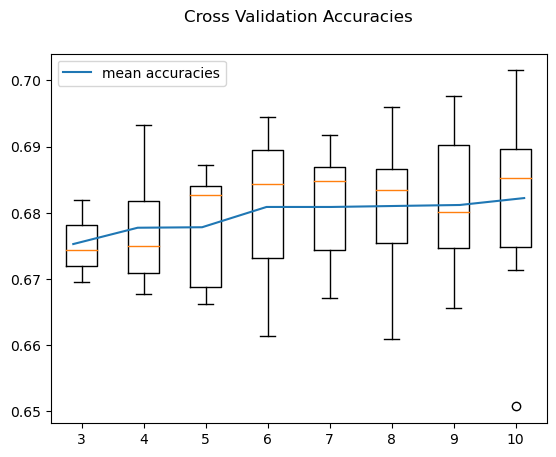

In [4]:
# plot cross validation accuracies
plt.boxplot(cross_validation_accs.values(), labels=list(range(3, 11)))
ax = plt.twiny()
avg_accs = [np.mean(accs) for accs in cross_validation_accs.values()]
ax.plot(avg_accs, label='mean accuracies')
ax.set_axis_off()
ax.legend(loc = 'upper left')
plt.title("Cross Validation Accuracies")

According to the graph above, it is clear that the 7-fold cross-validation has the best accuracies, considering the stablity and median accuracy. Hence, a rougly 86/14 split would be ideal for this dataset.

In [26]:
# use the optimal number of folds for the following analysis
cross_validator = KFold(n_splits=7)
split_indices = cross_validator.split(pca_feature, labels)

## 2. Modeling

The implementation of logistic regression must be written only from the examples given to you by the instructor. No credit will be assigned to teams that copy implementations from another source, regardless of if the code is properly cited. 

2.1 

Create a custom, one-versus-all logistic regression classifier using numpy and scipy to optimize. Use object oriented conventions identical to scikit-learn. You should start with the template developed by the instructor in the course. You should add the following functionality to the logistic regression classifier:
Ability to choose optimization technique when class is instantiated: either steepest ascent, stochastic gradient ascent, and Newton's method. It is recommended to call this the "solver" input for the class.

Update the gradient calculation to include a customizable regularization term (either using no regularization, L1 regularization, L2 regularization, or both L1 and L2 regularization). Associate a cost with the regularization term, "C", that can be adjusted when the class is instantiated.  

2.2

Train your classifier to achieve good generalization performance. That is, adjust the optimization technique and the value of the regularization term(s) "C" to achieve the best performance on your test set. Visualize the performance of the classifier versus the parameters you investigated.
Is your method of selecting parameters justified? That is, do you think there is any "data snooping" involved with this method of selecting parameters?


## 2.1  Create a custom, one-versus-all logistic regression classifier and using numpy, scipy and various solver methods to optimize.

In [27]:
import numpy as np


class BinaryLogisticRegressionBase:
    # private:
    def __init__(self, eta, iterations=20):
        self.eta = eta
        self.iters = iterations
        # internally we will store the weights as self.w_ to keep with sklearn conventions

    def __str__(self):
        return 'Base Binary Logistic Regression Object, Not Trainable'

    # convenience, private and static:
    @staticmethod
    def _sigmoid(theta):
        return 1/(1+np.exp(-theta))

    @staticmethod
    def _add_intercept(X):
        return np.hstack((np.ones((X.shape[0], 1)), X))  # add bias term

    # public:
    def predict_proba(self, X, add_intercept=True):
        # add bias term if requested
        Xb = self._add_intercept(X) if add_intercept else X
        return self._sigmoid(Xb @ self.w_)  # return the probability y=1

    def predict(self, X):
        return (self.predict_proba(X) > 0.5)  # return the actual prediction


blr = BinaryLogisticRegressionBase(0.1)
print(blr)

Base Binary Logistic Regression Object, Not Trainable


In [28]:
# inherit from base class
class BinaryLogisticRegression(BinaryLogisticRegressionBase):
    # private:
    def __str__(self):
        if (hasattr(self, 'w_')):
            # is we have trained the object
            return 'Binary Logistic Regression Object with coefficients:\n' + str(self.w_)
        else:
            return 'Untrained Binary Logistic Regression Object'

    def _get_gradient(self, X, y):
        # programming \sum_i (yi-g(xi))xi
        gradient = np.zeros(self.w_.shape)  # set gradient to zero
        for (xi, yi) in zip(X, y):
            # the actual update inside of sum
            gradi = (yi - self.predict_proba(xi, add_intercept=False))*xi
            # reshape to be column vector and add to gradient
            gradient += gradi.reshape(self.w_.shape)

        return gradient/float(len(y))

    # public:
    def fit(self, X, y):
        Xb = self._add_intercept(X)  # add bias term
        num_samples, num_features = Xb.shape

        self.w_ = np.zeros((num_features, 1))  # init weight vector to zeros

        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb, y)
            self.w_ += gradient*self.eta  # multiply by learning rate


blr = BinaryLogisticRegression(0.1)
print(blr)

Untrained Binary Logistic Regression Object


In [29]:
# train the classifier with the optimal number of folds and the pca data
for train_indices, test_indices in split_indices:
    X_train, y_train = pca_feature[train_indices], ((labels[train_indices]) > 1)
    X_test, y_test = pca_feature[test_indices], ((labels[test_indices]) > 1)

# train the classifier with the pca data
# X = pca_feature
# Y = labels > 1
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# train the classifier
blr = BinaryLogisticRegression(eta=0.1, iterations=12)
blr.fit(X_train, y_train)
print(blr)

yhat = blr.predict(X_test)
print('Accuracy of: ', accuracy_score(y_test,yhat))

Binary Logistic Regression Object with coefficients:
[[-0.00029092]
 [ 0.04395626]
 [-0.22565824]
 [-0.248578  ]
 [ 0.10309809]
 [-0.07139034]
 [-0.0323019 ]
 [ 0.00401275]
 [ 0.05577395]]
Accuracy of:  0.7841087297438578


In [30]:
# Train the classifier with more iterations to check if the accuracy improves
params = dict(eta=0.01,
              iterations=500)

blr = BinaryLogisticRegression(**params)
blr.fit(X_train,y_train)
print(blr)
yhat = blr.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))

Binary Logistic Regression Object with coefficients:
[[ 0.01174409]
 [ 0.06053577]
 [-0.49916394]
 [-0.68773908]
 [ 0.32374941]
 [-0.24576778]
 [-0.11727782]
 [ 0.01352371]
 [ 0.20394337]]
Accuracy of:  0.8008363826450601


Use numpy and scipy expit to optimize the Logistic Regression Function

In [14]:
# Vectorized Programming for Logistic Regression
import numpy as np
from scipy.special import expit

class VectorBinaryLogisticRegression(BinaryLogisticRegression):
    # inherit from our previous class to get same functionality
    @staticmethod
    def _sigmoid(theta):
        # increase stability using expit which is more stable
        return expit(theta)  # 1/(1+np.exp(-theta))

    # overwrite the gradient calculation
    def _get_gradient(self, X, y):
        # get y difference
        ydiff = y-self.predict_proba(X, add_intercept=False).ravel()
        # make ydiff a column vector and multiply through
        gradient = np.mean(X * ydiff[:, np.newaxis], axis=0)

        return gradient.reshape(self.w_.shape)


# use same params as defined above
blr = VectorBinaryLogisticRegression(**params)
blr.fit(X_train, y_train)
print(blr.w_)
yhat = blr.predict(X_test)
print('Accuracy of Vectorized Programing for Regression: ', accuracy_score(y_test,yhat))

C:\Users\seren\AppData\Local\Temp\ipykernel_15296\1043485029.py:17: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  gradient = np.mean(X * ydiff[:, np.newaxis], axis=0)


[[ 0.01711285]
 [ 0.06151229]
 [-0.50023012]
 [-0.68692673]
 [ 0.32376052]
 [-0.24934156]
 [-0.12075615]
 [ 0.0245485 ]
 [ 0.2028872 ]]
Accuracy of Vectorized Programing for Regression:  0.799552071668533


One-versus-all to program a Multicalss Logistic Regression

In [31]:
class LogisticRegression:
    def __init__(self, eta, iterations=20):
        self.eta = eta
        self.iters = iterations

    def __str__(self):
        if (hasattr(self, 'w_')):
            # is we have trained the object
            return 'MultiClass Logistic Regression Object with coefficients:\n' + str(self.w_)
        else:
            return 'Untrained MultiClass Logistic Regression Object'

    def fit(self, X, y):
        num_samples, num_features = X.shape
        self.unique_ = np.unique(y)  # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = []  # will fill this array with binary classifiers

        for i, yval in enumerate(self.unique_):  # for each unique value
            y_binary = (y == yval)  # create a binary problem
            # train the binary classifier for this class
            blr = VectorBinaryLogisticRegression(self.eta,
                                                 self.iters)
            blr.fit(X, y_binary)
            # add the trained classifier to the list
            self.classifiers_.append(blr)

        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T

    def predict_proba(self, X):
        probs = []
        for blr in self.classifiers_:
            # get probability for each classifier
            probs.append(blr.predict_proba(X))

        return np.hstack(probs)  # make into single matrix

    def predict(self, X):
        # take argmax along row
        return self.unique_[np.argmax(self.predict_proba(X), axis=1)]


lr = LogisticRegression(0.1, 1500)
print(lr)

Untrained MultiClass Logistic Regression Object


In [32]:

# train the MultiClass classifier with the optimal number of folds and the pca data
for train_indices, test_indices in split_indices:
    X_train, y_train = pca_feature[train_indices], labels[train_indices]
    X_test, y_test = pca_feature[test_indices], labels[test_indices]


# # train the MultiClass classifier with the pca data without the optimal number of folds
# X = pca_feature
# y = labels
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


lr = LogisticRegression(**params)
lr.fit(X_train, y_train)
print(lr)

yhat = lr.predict(X_test)
print('Accuracy of: ', accuracy_score(y_test,yhat))

C:\Users\seren\AppData\Local\Temp\ipykernel_15296\1043485029.py:17: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  gradient = np.mean(X * ydiff[:, np.newaxis], axis=0)


MultiClass Logistic Regression Object with coefficients:
[[-0.01174409 -0.06053577  0.49916394  0.68773908 -0.32374941  0.24576778
   0.11727782 -0.01352371 -0.20394337]
 [ 0.01174409  0.06053577 -0.49916394 -0.68773908  0.32374941 -0.24576778
  -0.11727782  0.01352371  0.20394337]]
Accuracy of:  0.8008363826450601


Logistic Regression Class Boundaries

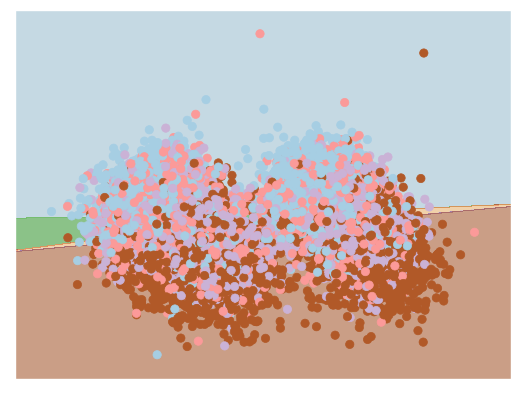

In [42]:
# linear boundaries visualization from sklearn documentation
from matplotlib import pyplot as plt
import copy
%matplotlib inline
plt.style.use('ggplot')

def plot_decision_boundaries(lr,Xin,y,title=''):
    Xb = copy.deepcopy(Xin)
    lr.fit(Xb[:,:2],y) # train only on two features

    h=0.01
    # create a mesh to plot in
    x_min, x_max = Xb[:, 0].min() - 1, Xb[:, 0].max() + 1
    y_min, y_max = Xb[:, 1].min() - 1, Xb[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # get prediction values
    Z = lr.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.5)

    # Plot also the training points
    plt.scatter(Xb[:, 0], Xb[:, 1], c=y, cmap=plt.cm.Paired)
    plt.xlabel('')
    plt.ylabel('')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(title)
    plt.show()
    
lr = LogisticRegression(0.1,1500) # OUR LR implementation
plot_decision_boundaries(lr,X,y)

Introduce L2-Norm parameter in the objective function to keep the values of the weights relatively small, with the purpose to control overfitting. Change the objective function by adding in a new summation fo the weights that reduces the maximum values when weights are large. 
To implemente this theory, using C as the hyperparameter to control the degree of opitimizing the previous function versus keeping the weight small.

In [36]:
class RegularizedBinaryLogisticRegression(VectorBinaryLogisticRegression):
    # extend init functions
    def __init__(self, C=0.0, **kwds):
        # need to add to the original initializer
        self.C = C
        # but keep other keywords
        super().__init__(**kwds)  # call parent initializer

    # extend previous class to change functionality
    def _get_gradient(self, X, y):
        # call get gradient from previous class
        gradient = super()._get_gradient(X, y)

        # add in regularization (to all except bias term)
        gradient[1:] += -2 * self.w_[1:] * self.C
        return gradient

In [37]:
# now redefine the Logistic Regression Function where needed
class RegularizedLogisticRegression(LogisticRegression):
    def __init__(self, C=0.0, **kwds):        
        self.C = C
        super().__init__(**kwds)
        
    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.unique(y) 
        num_unique_classes = len(self.unique_)
        self.classifiers_ = [] # will fill this array with binary classifiers
        
        for i,yval in enumerate(self.unique_): # for each unique value
            y_binary = y==yval # create a binary problem
            blr = RegularizedBinaryLogisticRegression(eta=self.eta,
                                                      iterations=self.iters,
                                                      C=self.C)
            blr.fit(X,y_binary)
            # add the trained classifier to the list
            self.classifiers_.append(blr)
            
        # save all the weights into one matrix, separate column for each class
        # now redefine the Logistic Regression Function where needed
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T

In [41]:
from ipywidgets import widgets as wd

cost_vals = np.logspace(-3, 1, 15) # 15 values from 0.001 to 10


def lr_explor(cost_idx): 
    C = cost_vals[cost_idx]
    lr_clf = RegularizedLogisticRegression(eta=0.1,
                                           # lots of iterations (to help overfit)
                                           iterations=2500,
                                           C=C)  # get object

    plot_decision_boundaries(lr_clf, X, y, title="C=%.5f" % (C))
    plt.show()


wd.interact(lr_explor, cost_idx=(0, 14, 1), __manual=True)

# what happens when C gets too large??
# let's explore the different values and see what happens

interactive(children=(IntSlider(value=7, description='cost_idx', max=14), Output()), _dom_classes=('widget-int…

<function __main__.lr_explor(cost_idx)>

##  Implemente optimization techniques
- Use a line search along gradient direction to find the right value of eta
    - Optimize eta, with all inputs constant
    - Do line search in gradient direction, using scipy function
    - Scipy minimize_scaler to optimize the obeject function, bounds and speed
    - Get the optimal learning rate
- Update the gradient calculation to include a customizable regularization term using L2 
 regularization. Set up **C** that can be adjusted when the class is instantiated.  

- Experimenting with various solver methods— stochastic gradient ascent, and Newton's method—when the class is instantiated

We will use data with optimal number of folds for the followings analysis as we have proved it has better performance compared to the data without implementing cross validation

In [57]:
# binary classification data
for train_indices, test_indices in split_indices:
    X_train, y_train = pca_feature[train_indices], (labels[train_indices] > 1)
    X_test, y_test = pca_feature[test_indices], (labels[test_indices] > 1 )

In [58]:
class BinaryLogisticRegression:
    def __init__(self, eta, iterations=20, C=0.001):
        self.eta = eta
        self.iters = iterations
        self.C = C
        # internally we will store the weights as self.w_ to keep with sklearn conventions

    def __str__(self):
        if (hasattr(self, 'w_')):
            return 'Binary Logistic Regression Object with coefficients:\n' + str(self.w_)
        else:
            return 'Untrained Binary Logistic Regression Object'

    # convenience, private:
    @staticmethod
    def _add_bias(X):
        return np.hstack((np.ones((X.shape[0], 1)), X))  # add bias term

    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta)  # 1/(1+np.exp(-theta))

    # vectorized gradient calculation with regularization using L2 Norm
    def _get_gradient(self, X, y):
        # get y difference
        ydiff = y-self.predict_proba(X, add_bias=False).ravel()
        # make ydiff a column vector and multiply through
        gradient = np.mean(X * ydiff[:, np.newaxis], axis=0)

        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += -2 * self.w_[1:] * self.C

        return gradient

    # public:
    def predict_proba(self, X, add_bias=True):
        # add bias term if requested
        Xb = self._add_bias(X) if add_bias else X
        return self._sigmoid(Xb @ self.w_)  # return the probability y=1

    def predict(self, X):
        return (self.predict_proba(X) > 0.5)  # return the actual prediction

    def fit(self, X, y):
        Xb = self._add_bias(X)  # add bias term
        num_samples, num_features = Xb.shape

        self.w_ = np.zeros((num_features, 1))  # init weight vector to zeros

        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb, y)
            self.w_ += gradient*self.eta  # multiply by learning rate
            # add bacause maximizing



In [59]:

blr = BinaryLogisticRegression(eta=0.1, iterations=50, C=0.001)

blr.fit(X_train, y_train)
print(blr)

yhat = blr.predict(X_test)
print('Accuracy of: ', accuracy_score(y_test, yhat))

Binary Logistic Regression Object with coefficients:
[[ 0.01170836]
 [ 0.06051586]
 [-0.50016486]
 [-0.68890173]
 [ 0.32397866]
 [-0.24565813]
 [-0.11706284]
 [ 0.01350007]
 [ 0.20346327]]
Accuracy of:  0.8008363826450601


In [60]:
#use a line search along the gradient direction:
from scipy.optimize import minimize_scalar
import copy
# (masked array) this has most numpy functions that work with NaN data.
from numpy import ma


class LineSearchLogisticRegression(BinaryLogisticRegression):

    # define custom line search for problem
    def __init__(self, line_iters=0.0, **kwds):
        self.line_iters = line_iters
        # but keep other keywords
        super().__init__(**kwds)  # call parent initializer

    # this defines the function with the first input to be optimized
    # therefore eta will be optimized, with all inputs constant
    @staticmethod
    def objective_function(eta, X, y, w, grad, C):
        wnew = w - grad*eta
        g = expit(X @ wnew)
        # the line search is looking for minimization, so take the negative of l(w)
        return -np.sum(ma.log(g[y == 1]))-ma.sum(ma.log(1-g[y == 0])) + C*sum(wnew**2)

    def fit(self, X, y):
        Xb = self._add_bias(X)  # add bias term
        num_samples, num_features = Xb.shape

        self.w_ = np.zeros((num_features, 1))  # init weight vector to zeros

        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = -self._get_gradient(Xb, y)
            # minimization is in opposite direction

            # do line search in gradient direction, using scipy function
            # unclear exactly what this should be
            opts = {'maxiter': self.line_iters}
            res = minimize_scalar(self.objective_function,  # objective function to optimize
                                  # bounds to optimize
                                  bounds=(0, self.eta*10),
                                  # additional argument for objective function
                                  args=(Xb, y, self.w_, gradient, self.C),
                                  method='bounded',  # bounded optimization for speed
                                  options=opts)  # set max iterations

            eta = res.x  # get optimal learning rate
            self.w_ -= gradient*eta  # set new function values
            # subtract to minimize


lslr = LineSearchLogisticRegression(eta=1.0,
                                    iterations=6,
                                    line_iters=8,
                                    C=0.001)

lslr.fit(X_train, y_train)

yhat = lslr.predict(X_test)
print("eta: ", lslr.eta)
print(lslr)
print('Accuracy of: ', accuracy_score(y_test,yhat))         

eta:  1.0
Binary Logistic Regression Object with coefficients:
[[ 0.09367245]
 [ 0.04085417]
 [-0.74545174]
 [-1.23769665]
 [ 0.67240934]
 [-0.55647988]
 [-0.27388939]
 [ 0.02347206]
 [ 0.47391496]]
Accuracy of:  0.8154730789336121


In [85]:
# import numpy as np


# class LinearSearchMultiClassLogisticRegression(LineSearchLogisticRegression):
#     def __init__(self, **kwds):
#         super().__init__(**kwds)  # call parent initializer
#         self.unique_ = None  # Ensure that this is defined here to avoid reference before assignment

#     def __str__(self):
#         if hasattr(self, 'w_'):
#             return 'MultiClass Logistic Regression Object with coefficients:\n' + str(self.w_)
#         else:
#             return 'Untrained MultiClass Logistic Regression Object'

#     def fit(self, X, y):
#         num_samples, num_features = X.shape
#         self.unique_ = np.unique(y)  # Correctly set each unique class value
#         self.classifiers_ = []  # will fill this array with binary classifiers

#         for yval in self.unique_:  # for each unique value
#             y_binary = (y == yval)  # create a binary problem
#             lblr = LineSearchLogisticRegression(eta=self.eta,
#                                                 iterations=self.iters,
#                                                 line_iters=self.line_iters,
#                                                 C=self.C)
#             lblr.fit(X, y_binary)
#             self.classifiers_.append(lblr)

#         self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T

#     def predict_proba(self, X):
#         if self.classifiers_ is None:
#             raise Exception(
#                 "This LinearSearchMultiClassLogisticRegression instance is not fitted yet.")
#         probs = [lblr.predict_proba(X) for lblr in self.classifiers_]
#         return np.hstack(probs)

#     def predict(self, X):
#         if self.unique_ is None:
#             raise Exception(
#                 "This LinearSearchMultiClassLogisticRegression instance is not fitted yet.")
#         return self.unique_[np.argmax(self.predict_proba(X), axis=1)]


# # Usage
# mul_lslr = LinearSearchMultiClassLogisticRegression(
#     eta=1.0, iterations=6, line_iters=8, C=0.001)
# print(mul_lslr)  # This will show it as untrained

# # Assuming 'split_indices' and your data are correctly defined and available
# for train_indices, test_indices in split_indices:
#     X_train, y_train = pca_feature[train_indices], labels[train_indices]
#     X_test, y_test = pca_feature[test_indices], labels[test_indices]
#     mul_lslr.fit(X_train, y_train)  # Fit the model

# print(mul_lslr)  # This should now show it as trained
# yhat = mul_lslr.predict(X_test)
# print('Accuracy of:', accuracy_score(y_test, yhat))

Performance has improved slightly, but not too much faster, mostly because $\eta$ was chosen well in the initial example

### Stochastic Gradient Descent
When calculating the gradient becomes too computationally intensive with large datasets, we can approximate the gradient using a single instance, with the underlying theory supporting the notion that the steps may appear somewhat random

In [61]:
class StochasticLogisticRegression(BinaryLogisticRegression):
    # stochastic gradient calculation
    def _get_gradient(self, X, y):

        # grab a subset of samples in a mini-batch
        # and calculate the gradient according to the small batch only
        mini_batch_size = 16
        idxs = np.random.choice(len(y), mini_batch_size)

        # get y difference (now scalar)
        ydiff = y[idxs]-self.predict_proba(X[idxs], add_bias=False).ravel()
        # make ydiff a column vector and multiply through
        gradient = np.mean(X[idxs] * ydiff[:, np.newaxis], axis=0)

        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += -2 * self.w_[1:] * self.C

        return gradient


slr = StochasticLogisticRegression(
    eta=0.01, iterations=300, C=0.001)  # take a lot more steps!!

slr.fit(X_train, y_train)

yhat = slr.predict(X_test)
print(slr)
print('Accuracy of: ', accuracy_score(y_test,yhat))      

Binary Logistic Regression Object with coefficients:
[[ 7.35870475e-03]
 [ 6.93276220e-02]
 [-4.14291895e-01]
 [-4.92546384e-01]
 [ 2.18879496e-01]
 [-1.72137850e-01]
 [-7.79582402e-02]
 [ 4.92393085e-04]
 [ 1.27357819e-01]]
Accuracy of:  0.7982226868792472


### Newton's Update Method - Hessian
- In multiple dimensions when dealing with functions of several variables, this involves using the Hessian matrix (a square matrix of second-order partial derivatives of the function) and the gradient of the function. This method is used to find points where the function reaches its local maxima or minima. The inclusion of the Hessian allows Newton's method to consider the curvature of the function, potentially leading to faster convergence compared to methods that only use the first derivative, such as Gradient Descent.

References:
- https://www.quora.com/Why-is-Newtons-method-only-appropriate-when-the-Hessian-is-positive-definite
- https://www.khanacademy.org/math/multivariable-calculus/applications-of-multivariable-derivatives/quadratic-approximations/a/the-hessian



In [62]:
# code Hessian up using numpy:

from numpy.linalg import pinv


class HessianBinaryLogisticRegression(BinaryLogisticRegression):
    # just overwrite gradient function
    def _get_gradient(self, X, y):
        # get sigmoid value for all classes
        g = self.predict_proba(X, add_bias=False).ravel()
        hessian = X.T @ np.diag(g*(1-g)) @ X - 2 * \
            self.C  # calculate the hessian

        ydiff = y-g  # get y difference
        # make ydiff a column vector and multiply through
        gradient = np.sum(X * ydiff[:, np.newaxis], axis=0)
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += -2 * self.w_[1:] * self.C

        return pinv(hessian) @ gradient


hlr = HessianBinaryLogisticRegression(eta=1.0,
                                      iterations=4,
                                      C=0.001)  # note that we need only a few iterations here

hlr.fit(X_train, y_train)
yhat = hlr.predict(X_test)
print(hlr)
print('Accuracy of: ', accuracy_score(y_test,yhat))


Binary Logistic Regression Object with coefficients:
[[ 0.23638944]
 [ 0.09982295]
 [-1.00021084]
 [-1.74812429]
 [ 1.05315017]
 [-0.98454332]
 [-0.67658935]
 [ 0.05085698]
 [ 1.49621441]]
Accuracy of:  0.8332462101411395


#### Observation: Stochastic Gradient Descent demonstrates lower accuracy compared to the method using Newton's Update with the Hessian matrix. Therefore, it is recommended to continue building the Multiclass Classifier using the Hessian method. 

In [78]:
# for this, we won't perform our own BFGS implementation to see if we can do better with scipy for Hessian

# luckily for us, scipy has its own BFGS implementation:

from scipy.optimize import fmin_bfgs
from scipy.optimize import fmin_bfgs
from numpy import ma


class BFGSBinaryLogisticRegression(BinaryLogisticRegression):

    @staticmethod
    def objective_function(w, X, y, C):
        g = expit(X @ w)
        # invert this because scipy minimizes, but we derived all formulas for maximzing
        return -ma.sum(ma.log(g[y == 1]))-ma.sum(ma.log(1-g[y == 0])) + C*sum(w**2)
        # -np.sum(y*np.log(g)+(1-y)*np.log(1-g))

    @staticmethod
    def objective_gradient(w, X, y, C):
        g = expit(X @ w)
        ydiff = y-g  # get y difference
        gradient = np.mean(X * ydiff[:, np.newaxis], axis=0)
        gradient = gradient.reshape(w.shape)
        gradient[1:] += -2 * w[1:] * C
        return -gradient

    # just overwrite fit function
    def fit(self, X, y):
        Xb = self._add_bias(X)  # add bias term
        num_samples, num_features = Xb.shape

        self.w_ = fmin_bfgs(self.objective_function,  # what to optimize
                            np.zeros((num_features, 1)),  # starting point
                            fprime=self.objective_gradient,  # gradient function
                            # extra args for gradient and objective function
                            args=(Xb, y, self.C),
                            gtol=1e-03,  # stopping criteria for gradient, |v_k|
                            maxiter=self.iters,  # stopping criteria iterations
                            disp=False)

        self.w_ = self.w_.reshape((num_features, 1))


# note that we need only a few iterations here
bfgslr = BFGSBinaryLogisticRegression(_, iterations=3, C=0.001)

bfgslr.fit(X_train, y_train)
yhat = bfgslr.predict(X_test)
print(bfgslr)
print('Accuracy of: ', accuracy_score(y_test,yhat))

Binary Logistic Regression Object with coefficients:
[[ 0.01535405]
 [ 0.07412901]
 [-0.78817433]
 [-1.0732757 ]
 [ 0.48730721]
 [-0.35556927]
 [-0.16370402]
 [ 0.01889513]
 [ 0.28151004]]
Accuracy of:  0.796131730266597


In [79]:
class MultiClassLogisticRegression:
    def __init__(self, eta, iterations=20,
                 C=0.0001,
                 solver=BFGSBinaryLogisticRegression):
        self.eta = eta
        self.iters = iterations
        self.C = C
        self.solver = solver
        self.classifiers_ = []
        # internally we will store the weights as self.w_ to keep with sklearn conventions

    def __str__(self):
        if (hasattr(self, 'w_')):
            # is we have trained the object
            return 'MultiClass Logistic Regression Object with coefficients:\n' + str(self.w_)
        else:
            return 'Untrained MultiClass Logistic Regression Object'

    def fit(self, X, y):
        num_samples, num_features = X.shape
        self.unique_ = np.sort(np.unique(y))  # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = []
        for i, yval in enumerate(self.unique_):  # for each unique value
            y_binary = np.array(y == yval).astype(
                int)  # create a binary problem
            # train the binary classifier for this class

            hblr = self.solver(eta=self.eta, iterations=self.iters, C=self.C)
            hblr.fit(X, y_binary)

            # add the trained classifier to the list
            self.classifiers_.append(hblr)

        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T

    def predict_proba(self, X):
        probs = []
        for hblr in self.classifiers_:
            # get probability for each classifier
            probs.append(hblr.predict_proba(X).reshape((len(X), 1)))

        return np.hstack(probs)  # make into single matrix

    def predict(self, X):
        return self.unique_[np.argmax(self.predict_proba(X), axis=1)] # take argmax along row

In [80]:
# train the MultiClass classifier
for train_indices, test_indices in split_indices:
    X_train, y_train = pca_feature[train_indices], (labels[train_indices])
    X_test, y_test = pca_feature[test_indices], (labels[test_indices])

lr = MultiClassLogisticRegression(eta=1.0,
                                  iterations=5,
                                  C=0.001,
                                  solver=HessianBinaryLogisticRegression
                                  )
lr.fit(X_train, y_train)
print(lr)

yhat = lr.predict(X_test)
print('Accuracy of: ', accuracy_score(y_test, yhat))

MultiClass Logistic Regression Object with coefficients:
[[-0.23801312 -0.10016086  1.00354372  1.7543245  -1.05701163  0.98820404
   0.67876754 -0.05088131 -1.50072152]
 [ 0.23801312  0.10016086 -1.00354372 -1.7543245   1.05701163 -0.98820404
  -0.67876754  0.05088131  1.50072152]]
Accuracy of:  0.8332462101411395


## 2.2 Train your classifier to achieve good generalization performance. 
That is, adjust the optimization technique and the value of the regularization term(s) "C" to achieve the best performance on your test set. Visualize the performance of the classifier versus the parameters you investigated.



**Questions:** 
- Is your method of selecting parameters justified? That is, do you think there is any "data snooping" involved with this method of selecting parameters?

References:
1. https://www.kaggle.com/datasets/kukuroo3/body-performance-data
2. https://www.bigdata-culture.kr/bigdata/user/data_market/detail.do?id=ace0aea7-5eee-48b9-b616-637365d665c1
3. https://www.quora.com/Why-is-Newtons-method-only-appropriate-when-the-Hessian-is-positive-definite
4. https://www.khanacademy.org/math/multivariable-calculus/applications-of-multivariable-derivatives/quadratic-approximations/a/the-hessian